In [207]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report

from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score, fowlkes_mallows_score, adjusted_mutual_info_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import SparseRandomProjection as RCA
from collections import defaultdict
from itertools import product
from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.ensemble import RandomForestClassifier

import os

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from libs.loader import load_malicious, load_jobchange, load_jobchange_test_untouched, load_malicious_test_untouched, load_jobchange_w_headers, load_malicious_w_headers
         

from sklearn.model_selection import learning_curve, validation_curve

In [209]:
#Load the two datset
job_data = load_jobchange()
mal_data = load_malicious()

_X_job,y_job = job_data
_X_mal,y_mal = mal_data


maMaxNorm = MinMaxScaler()
X_job = minMaxNorm.fit_transform(_X_job)
X_mal = minMaxNorm.fit_transform(_X_mal)

_X_test_mal, y_test_mal = load_malicious_test_untouched()
_X_test_job, y_test_job = load_jobchange_test_untouched()
X_test_mal = minMaxNorm.fit_transform(_X_test_mal)
X_test_job = minMaxNorm.fit_transform(_X_test_job)

RND_STATE=998756

LABELS_MAL=['X_1','X_2','X_3','X_4','X_5','X_6','X_7','X_8','X_9','X_10','X_11','X_12','X_13','X_14','X_15']
LABELS_JOB=['city','city_development_index','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job','training_hours']

PLOT_DIR = 'plots/kmeans'
OUTPUT_DIR = 'output'
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [34]:


def get_kmean_scores(X, y, N):


    def get_kmean(n):
        km = KMeans(n_clusters=n,random_state=RND_STATE, max_iter=500 )
        km.fit(X)
        km_labels = km.predict(X)
        ss = silhouette_score(X, km_labels, metric='euclidean')
        sse_i = km.inertia_
        hom = homogeneity_score(y, km_labels)
        fowm = fowlkes_mallows_score(y, km_labels)
        ami = adjusted_mutual_info_score(y,km_labels)
        return ss,sse_i, hom, fowm, ami
    
  
    
    n_rng = np.arange(2,N+1)
    scores_df = pd.DataFrame()

    for n in n_rng:
        results = {'n':n}
        ss_km, sse, hom, fowm, ami = get_kmean(n)            
        results[ f"sil"] =  ss_km; results[f"sse"] = sse; results[f"hom"] = hom; results[f"fowm"] = fowm; results[f"ami"] = ami
        print(f" done with N: {n}")
        
        scores_df = scores_df.append(results, ignore_index=True)
            

    return scores_df

In [52]:
def plot_elbow_kmeans(k_metric_df, name='dsname', short_name='shortname', face_color=None):
    
    figsave=False
    
    
    fig = plt.figure(figsize=[20,3])
    ax1 = fig.add_subplot(151)
    ax2 = fig.add_subplot(152)
    ax3 = fig.add_subplot(153)
    ax4 = fig.add_subplot(154)
    ax5 = fig.add_subplot(155)
    allAxs = [ax1, ax2, ax3, ax4, ax5] 

    
    x_vals = k_metric_df['n'].values
    x_vals = x_vals.astype('int32')

    cumsse = np.cumsum(k_metric_df['sse'])
    cumsse = cumsse/cumsse[0]

    ax1.plot(x_vals, k_metric_df['sil'])
    ax2.plot(x_vals, cumsse)
    ax3.plot(x_vals, k_metric_df['hom'])
    ax4.plot(x_vals, k_metric_df['fowm'])
    ax5.plot(x_vals, k_metric_df['ami'])
   
    
    for ax in allAxs:
        if face_color != None:
            ax.set_facecolor(face_color)
        ax.set_xticks(x_vals)
        ax.grid(True)

    ax2.set_yticks([])
    ax1.set_ylabel("Silhouette Score"); ax1.set_xlabel("N clusters")
    ax2.set_ylabel("SSE Variation"); ax2.set_xlabel("N clusters")
    ax3.set_ylabel("Homogeneity Score"); ax3.set_xlabel("N clusters")
    ax4.set_ylabel("Fowlkes-Mallows Score"); ax4.set_xlabel("N clusters")
    ax5.set_ylabel("AMI Score"); ax5.set_xlabel("N clusters")

    ax1.set_title('Kmeans: Elbow silhouette score\n  dataset: %s '%name)
    ax2.set_title('Kmeans: SSE.\n  dataset: %s '%name)
    ax3.set_title('Kmeans: Homogeneity score\n  dataset: %s '%name)
    ax4.set_title('Kmeans: Fowlkes-Mallows score\n  dataset: %s '%name)
    ax5.set_title('Kmeans: Ajusted Mutual Information score\n  dataset: %s '%name)



    fig.tight_layout()

    if figsave:
        fig.savefig('plots/kmeans_%s_results.png'%short_name, bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()

In [60]:
def cumsum_plotter(cumulativeSum):
    
    data = [n for n in range(len(cumulativeSum))]

    plt.figure(figsize=(10, 10))
    plt.plot(data, cumulativeSum, color='red', label='cumulative explained variance')
    plt.title('Cumulative Explained Variance vs Number of Components')
    plt.ylabel('Cumulative Explained variance')
    plt.xlabel('Principal components')
    plt.yticks([])
    plt.legend(loc='best')


In [13]:


scores_df_mal = get_kmean_scores(X_mal, y_mal, 10)

 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10


In [54]:
scores_df_job = get_kmean_scores(X_job, y_job, 9)

 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9


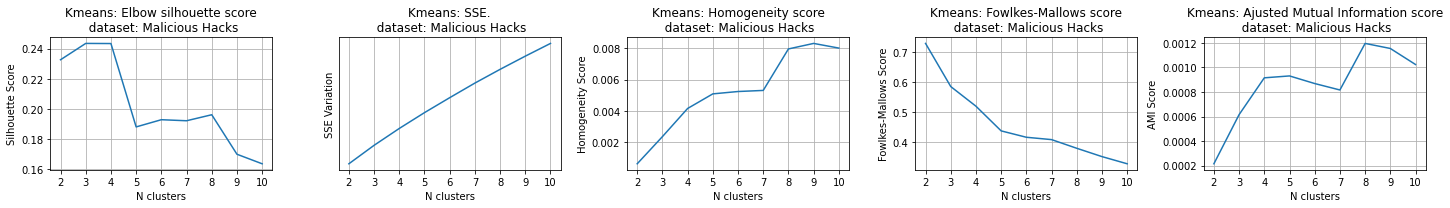

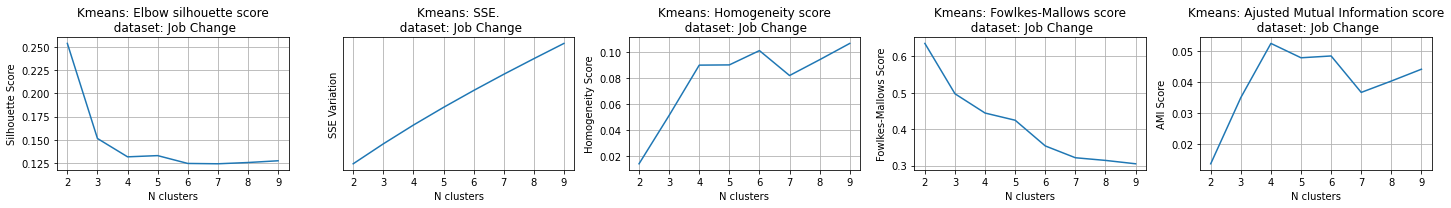

In [85]:
plot_elbow_kmeans(scores_df_mal, 'Malicious Hacks', 'mal')
plot_elbow_kmeans(scores_df_job, 'Job Change', 'job')

In [15]:
def max_kurtosis_indexes(X_projected, cutoff):
    tmp = pd.DataFrame(X_projected)
    tmp = tmp.kurt(axis=0)
    kurt = tmp.sort_values(ascending=False)
        
    max_k = kurt[0:cutoff]
    print(f"Top-{cutoff} Max Kurtosis -- ")
    print(max_k)
    print(max_k.index)
    return max_k.index
    
    

In [16]:
def ica_max_kurtosis(X, cutoff, dim=0):

    if dim == 0:
        dim = X.shape[1]-1
    elif dim < cutoff:
        dim = cutoff

    ica = FastICA(random_state=89143)
    ica.set_params(n_components=dim)
    X_projected = ica.fit_transform(X)

    max_k_idexes = max_kurtosis_indexes(X_projected,cutoff)
    
    X_proj_df = pd.DataFrame(X_projected)
    X_proj_df  = X_proj_df.filter( max_k_idexes, axis=1 )
        
    return X_proj_df
    

In [127]:
def pca(X, cutoff_per, var_threashold):
    pca = PCA(cutoff_per, random_state=RND_STATE)
    pca.fit(X)
    pca.explained_variance_

    row_index = range(1, pca.explained_variance_.shape[0] + 1)
    ev = pd.Series(data=pca.explained_variance_, index=row_index)
    evr = pd.Series(data=pca.explained_variance_ratio_, index=row_index)
    eigen = pd.Series(data=pca.singular_values_, index=row_index)

    
    pca_stats_df = pd.DataFrame()
    pca_stats_df['pca_stats_df'] = ev
    pca_stats_df['e-variance-ratio'] = evr
    pca_stats_df['eigen'] = eigen

    if (var_threashold > 0):
        var_above = pca_stats_df[pca_stats_df['pca_stats_df'] >= var_threashold]
    else:
        var_above = pca_stats_df
    print("Original PCA components")
    print(pca_stats_df)
    print(f"Threshold PCA components variance >= [{var_threashold:.2f}%]")
    print(var_above)
  
    constrained_cols = var_above.index-1
    X_pca_projected = pca.transform(X)

    return pd.DataFrame(X_pca_projected).filter(constrained_cols, axis=1)

In [ ]:
def pca_km_research(X):
    dim = X.shape[1]
    print(f"Running PCA with {dim}")
    pca = PCA( random_state=RND_STATE)
    pca.fit(X)
    cumulativeSum = np.cumsum(pca.explained_variance_ratio_) * 100
    cumsum_plotter(cumulativeSum)
_ =pca_km_research(X_mal)

_ =pca_km_research(X_job)


In [71]:
def rp(X, dim, r_state=RND_STATE):
    rp = RCA(random_state=r_state, n_components=dim)
    fitted = rp.fit(X)
    X_rca_projected = rp.transform(X)
    return pd.DataFrame(X_rca_projected)
    

In [32]:
def rfc_research(X,y):
                 
        rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RND_STATE, n_jobs=-1)
        fs = rfc.fit(X,y).feature_importances_

#         important_features = pd.Series(np.sort(fs)[::-1])
        return fs
        
def rfc(X,y):
                 
        rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RND_STATE, n_jobs=-1)
        fs = rfc.fit(X,y).feature_importances_
        indexes_found = np.where(fs >= 0.10)
        
        X_reduced = pd.DataFrame(X)
        X_reduced = X_reduced.filter(indexes_found[0], axis=1)
        return X_reduced

## ALL Projections!

In [130]:

#KEY CODE BLOCK!!!
print(f"---- RUNNING ICA -------")
X_ica_proj_mal = ica_max_kurtosis(X_mal ,3, dim=12)
X_ica_proj_job = ica_max_kurtosis(X_job ,2, dim=11)

print(f"\n---- RUNNING PCA -------")
X_pca_proj_mal = pca(X_mal, 0.80, 0.08)  #was 0.80, .10
X_pca_proj_job = pca(X_job, 0.80, 0.11) #was 0.80, .10

print(f"\n---- RUNNING RP -------")
r_states = [89143, 92, 1081244453, 8772, 212]
X_rp_proj_mal = []; X_rp_proj_job = []
for r in r_states:
    X_rp_mal = rp(X_mal,3, r)
    X_rp_job = rp(X_job,3, r)
    X_rp_proj_mal.append(X_rp_mal); X_rp_proj_job.append(X_rp_job)

print(f"\n---- RUNNING Random Forest RFC -------")
X_rfc_proj_mal = rfc(X_mal,y_mal)
X_rfc_proj_job = rfc(X_job,y_job)
print(f"Shapes for rfc:  mal.shape {X_rfc_proj_mal.shape} job.shape {X_rfc_proj_job.shape}")

---- RUNNING ICA -------
Top-3 Max Kurtosis -- 
4     979.059926
10     16.442754
3       9.372346
dtype: float64
Int64Index([4, 10, 3], dtype='int64')
Top-2 Max Kurtosis -- 
2    4.070954
6    2.281712
dtype: float64
Int64Index([2, 6], dtype='int64')

---- RUNNING PCA -------
Original PCA components
   pca_stats_df  e-variance-ratio      eigen
1      0.233921          0.268764  66.812563
2      0.126357          0.145178  49.104657
3      0.104607          0.120188  44.679041
4      0.098900          0.113632  43.443266
5      0.077852          0.089448  38.544098
6      0.057066          0.065566  32.999864
Threshold PCA components variance >= [0.08%]
   pca_stats_df  e-variance-ratio      eigen
1      0.233921          0.268764  66.812563
2      0.126357          0.145178  49.104657
3      0.104607          0.120188  44.679041
4      0.098900          0.113632  43.443266
Original PCA components
   pca_stats_df  e-variance-ratio      eigen
1      0.262442          0.243139  63.418657

In [ ]:
print("Starting ICA Mal")
scores_df_ica_mal = get_kmean_scores(X_ica_proj_mal, y_mal, 7)
print("Starting ICA Job")
scores_df_ica_job = get_kmean_scores(X_ica_proj_job, y_job, 7)

In [132]:
print("Starting PCA scores Mal")
scores_df_pca_mal = get_kmean_scores(X_pca_proj_mal, y_mal, 10)
print("Starting PCA scores Job")
scores_df_pca_job = get_kmean_scores(X_pca_proj_job, y_job, 9)

Starting PCA scores Mal
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9
 done with N: 10
Starting PCA scores Job
 done with N: 2
 done with N: 3
 done with N: 4
 done with N: 5
 done with N: 6
 done with N: 7
 done with N: 8
 done with N: 9


In [ ]:
scores_df_rp_mal = []; scores_df_rp_job =[]
for i in range(len(X_rp_proj_mal)):
    print(f"Starting RP scores Mal [{i}]")
    scores_df_rp_mal.append(get_kmean_scores(X_rp_proj_mal[i], y_mal, 6))
    print(f"Starting RP scores Job [{i}]")
    scores_df_rp_job.append(get_kmean_scores(X_rp_proj_job[i], y_job, 6))

In [ ]:
print("Starting RFC scores Mal")
scores_df_rfc_mal = get_kmean_scores(X_rfc_proj_mal, y_mal, 10)
print("Starting RFC scores Job")
scores_df_rfc_job = get_kmean_scores(X_rfc_proj_job, y_job, 9)

In [40]:
def merge_scores_df_list(scores_df_list):
    scores_all_df = pd.DataFrame(scores_df_list[0])
    for i in range(1,len(scores_df_list)):
        scores_all_df += scores_df_list[i]
    
    scores_all_df = scores_all_df / len(scores_df_list)
    return scores_all_df

## PLOT ALL Dim Reductions

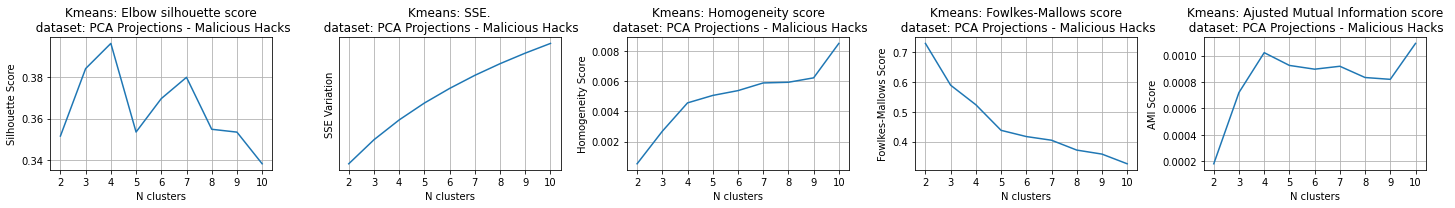

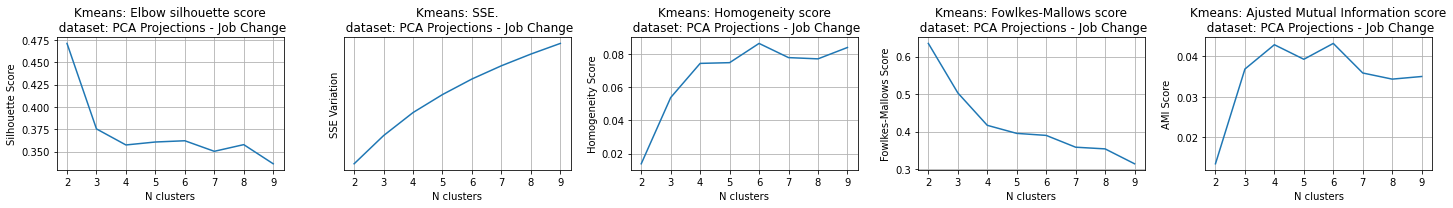

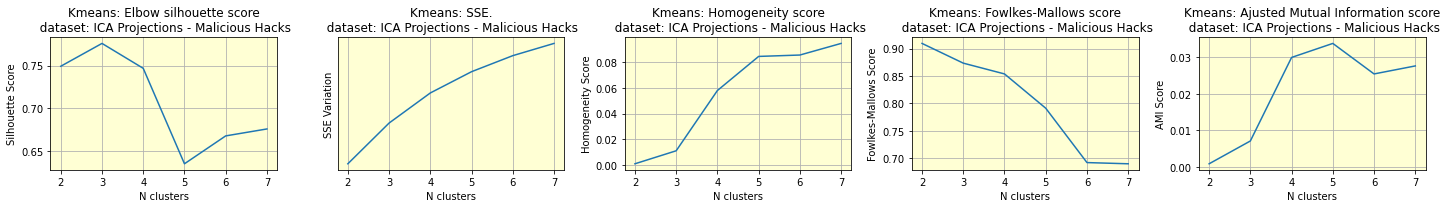

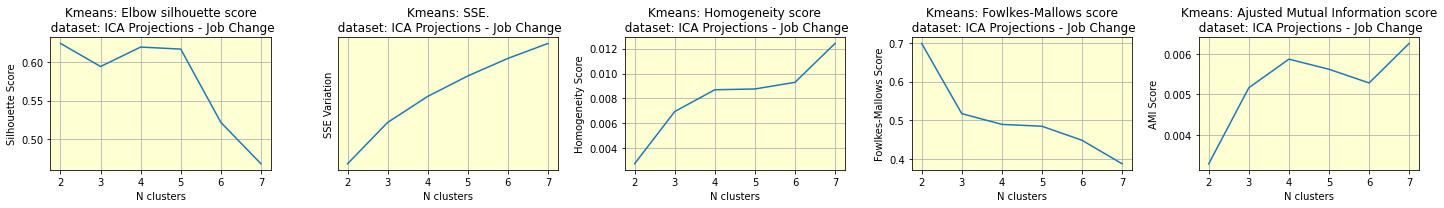

(5, 6), (5, 6)


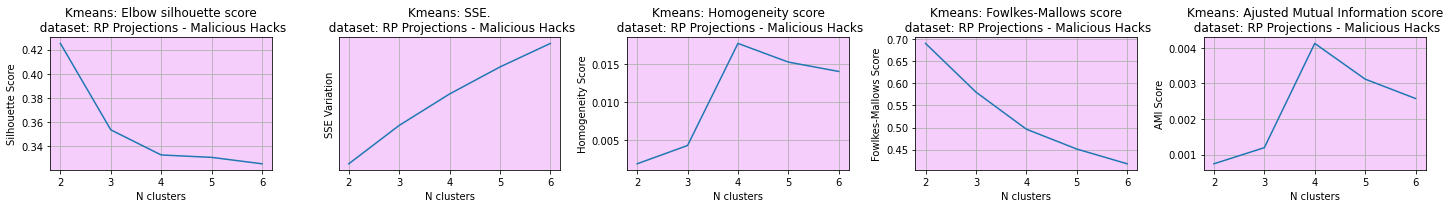

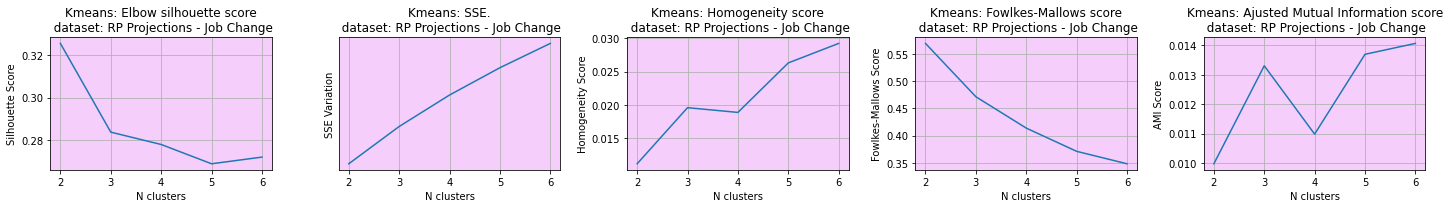

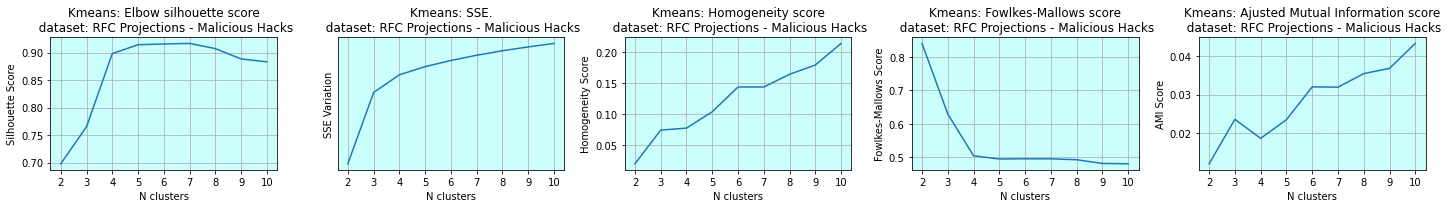

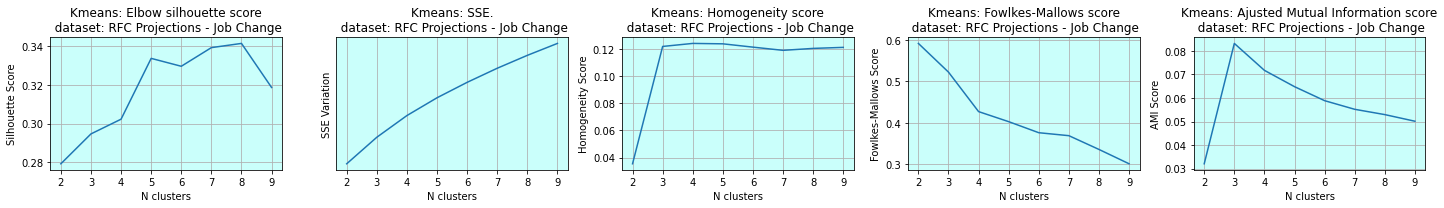

In [140]:

plot_elbow_kmeans(scores_df_pca_mal, 'PCA Projections - Malicious Hacks', 'pca_mal')
plot_elbow_kmeans(scores_df_pca_job, 'PCA Projections - Job Change', 'pca_job')

plot_elbow_kmeans(scores_df_ica_mal, 'ICA Projections - Malicious Hacks', 'ica_mal', face_color='#ffffd4')
plot_elbow_kmeans(scores_df_ica_job, 'ICA Projections - Job Change', 'ica_job',face_color='#ffffd4')

scores_all_df_rp_mal = merge_scores_df_list(scores_df_rp_mal)
scores_all_df_rp_job = merge_scores_df_list(scores_df_rp_job)
print(f"{scores_all_df_rp_mal.shape}, {scores_df_rp_mal[0].shape}")
plot_elbow_kmeans(scores_all_df_rp_mal, 'RP Projections - Malicious Hacks', 'rp_mal', face_color='#f6cefc')
plot_elbow_kmeans(scores_all_df_rp_job, 'RP Projections - Job Change', 'rp_job',face_color='#f6cefc')

plot_elbow_kmeans(scores_df_rfc_mal, 'RFC Projections - Malicious Hacks', 'rfc_mal', face_color='#cafffb')
plot_elbow_kmeans(scores_df_rfc_job, 'RFC Projections - Job Change', 'rfc_job',face_color='#cafffb')

In [243]:
def plot_km_pairwise(X, N, title, d_key, best=False, pred_override=None):
    
    km = KMeans(n_clusters=N,random_state=RND_STATE, max_iter=500 )
    km.fit(X)
    pred_clusters = km.predict(X)


    filtred_df = X.copy()
 
        
    filtred_df['pred'] = pred_clusters if pred_override == None else pred_override
    
    
    y_vars = filtred_df.columns[0:1]
    if best:
        x_vars = filtred_df.columns[:2]
    else:
        x_vars = filtred_df.columns[:-1]
    ax = sns.PairGrid(filtred_df, hue="pred", x_vars=x_vars, y_vars=y_vars)
    ax.map_diag(sns.histplot, color=".3")
    ax.map_offdiag(sns.scatterplot)
    ax.add_legend()
    ax.fig.suptitle("%s, Kmeans, N-cluster = %d"%(title,N), y=1.08)


In [137]:
def plot_em_pairwise(X, N, cv_type, title, d_key, best=False):
    
    gmm = GMM(n_components=N, covariance_type=cv_type, random_state=RND_STATE)
    gmm.fit(X)
    pred_clusters = gmm.predict(X)


    filtred_df = X.copy()
 
        
    filtred_df['pred'] = pred_clusters
    y_vars = filtred_df.columns[0:1]
    if best:
        x_vars = filtred_df.columns[:2]
    else:
        x_vars = filtred_df.columns[:-1]
    ax = sns.PairGrid(filtred_df, hue="pred", x_vars=x_vars, y_vars=y_vars)
    ax.map_diag(sns.histplot, color=".3")
    ax.map_offdiag(sns.scatterplot)
    ax.add_legend()
    ax.fig.suptitle("%s, EM, N-cluster = %d"%(title,N), y=1.08)


In [ ]:
mal_pair_df = pd.DataFrame(X_mal)
filtred_df = mal_pair_df.filter(['X_2','X_3','X_6','X_9','X_10','X_11'], axis=1)
plot_km_pairwise(filtred_df.values, 4, 'PCA Malcious Hacks', 'mal', pred_override=y_mal)
# plot_km_pairwise(X_pca_proj_job, 2, 'PCA Job Change', 'job', best=True)
# plot_em_pairwise(X_pca_proj_mal, 4, 'tied', 'PCA Malcious Hacks', 'mal', best=True)

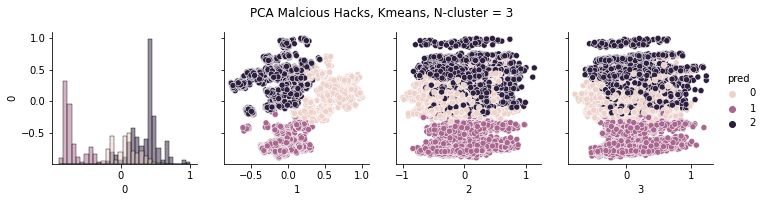

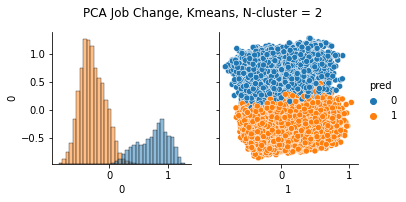

In [247]:
plot_km_pairwise(X_pca_proj_mal, 3, 'PCA Malcious Hacks', 'mal')
plot_km_pairwise(X_pca_proj_job, 2, 'PCA Job Change', 'job', best=True)

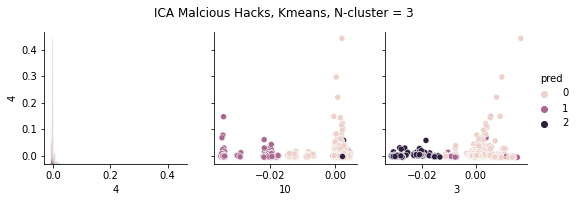

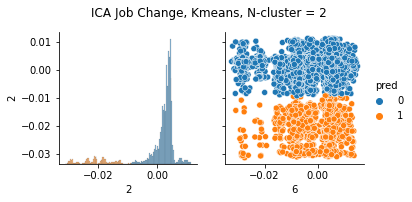

In [249]:
plot_km_pairwise(X_ica_proj_mal, 3, 'ICA Malcious Hacks', 'mal')
plot_km_pairwise(X_ica_proj_job, 2, 'ICA Job Change', 'job', best=True)


(19084, 3)


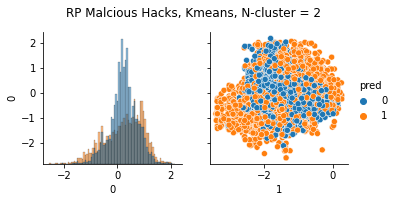

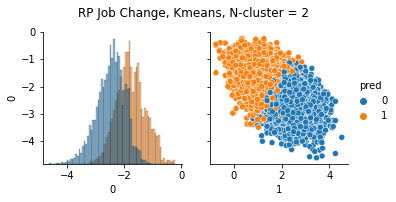

In [157]:
print(X_rp_proj_mal[1].shape)
plot_km_pairwise(X_rp_proj_mal[1], 2, 'RP Malcious Hacks', 'mal', best=True)
plot_km_pairwise(X_rp_proj_job[1], 2, 'RP Job Change', 'job', best=True)

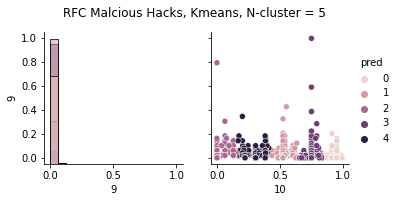

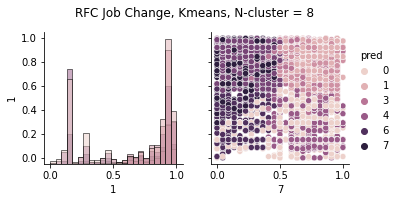

In [147]:
plot_km_pairwise(X_rfc_proj_mal, 5, 'RFC Malcious Hacks', 'mal', best=True)
plot_km_pairwise(X_rfc_proj_job, 8, 'RFC Job Change', 'job', best=True)

In [ ]:
plot_km_pairwise(X_ica_proj_mal, 3, 'ICA Malcious Hacks', 'mal')
plot_km_pairwise(X_ica_proj_job, 2, 'ICA Job Change', 'job', best=True)

In [177]:
def basic_km_plot_axis(k_metric_df, col_name, face_color=None):
        
    fig, ax1 = plt.subplots(1, 1, figsize=(3,3))

    x_vals = k_metric_df['n'].values
    x_vals = x_vals.astype('int32')

    ax1.plot(x_vals, k_metric_df[col_name])

   
    if face_color != None:
        ax1.set_facecolor(face_color)
    ax1.set_xticks(x_vals)
    ax1.grid(True)
    return fig, ax1
    

In [211]:
def save_sse_plot(k_metric_df, name='dsname', short_name='shortname', projection=None, face_color=None,figsave=True):
    
    n_limit = 6
    
    fig, ax1 = plt.subplots(1, 1, figsize=(3,3))

    x_vals = k_metric_df['n'].values
    x_vals = x_vals.astype('int32')
    x_vals = x_vals[:n_limit]
    
    cumsse = np.cumsum(k_metric_df['sse'])
    cumsse = cumsse/cumsse[0]

    ax1.plot(x_vals, cumsse[:n_limit])

   
    if face_color != None:
        ax1.set_facecolor(face_color)
    ax1.set_xticks(x_vals)
    ax1.grid(True)

    ax1.set_ylabel("SSE Variation"); ax1.set_xlabel("N clusters")

    title_ = 'Kmeans: SSE Variation\nDataset: %s '%name
    if projection:
        title_ = title_ + '\nDR-Projection: %s'%projection
    ax1.set_title(title_)
    
    fig.tight_layout()

    if figsave:
        fig.savefig('%s/clust_sse_%s.png'%(PLOT_DIR,short_name), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()

In [236]:
def save_silhoette_plot(k_metric_df, name='dsname', short_name='shortname', projection=None, face_color=None,figsave=True):
    
    fig, ax1 = basic_km_plot_axis(k_metric_df, 'sil', face_color)

    ax1.set_ylabel("Silhouette Score"); ax1.set_xlabel("N clusters")
    
    title_ = 'Kmeans: Silhouette Score.\nDataset: %s '%name
    if projection:
        title_ = title_ + '\nDR-Projection: %s'%projection
    ax1.set_title(title_)
    
    fig.tight_layout()

    if figsave:
        fig.savefig('%s/clust_sil_%s.png'%(PLOT_DIR,short_name), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()

In [237]:
def save_fmi_plot(k_metric_df, name='dsname', short_name='shortname', projection=None, face_color=None,figsave=True):
    
    fig, ax1 = basic_km_plot_axis(k_metric_df, 'fowm', face_color)

    ax1.set_ylabel("FMI Score"); ax1.set_xlabel("N clusters")
    
    title_ = 'Kmeans: Fowlkes-Mallows score\nDataset: %s '%name
    if projection:
        title_ = title_ + '\nDR-Projection: %s'%projection
    ax1.set_title(title_)
    
    fig.tight_layout()

    if figsave:
        fig.savefig('%s/clust_fmi_%s.png'%(PLOT_DIR,short_name), bbox_inches='tight')
        plt.close(fig=fig)
    else:
        plt.show()

In [250]:
#RAW plots
save_silhoette_plot(scores_df_mal, 'Malicious Server Hacks', 'mal')
save_silhoette_plot(scores_df_job, 'Job Change', 'job')
save_fmi_plot(scores_df_mal, 'Malicious Server Hacks', 'mal')
save_sse_plot(scores_df_mal, 'Malicious Server Hacks', 'mal')
save_sse_plot(scores_df_job, 'Job Change', 'job')
save_fmi_plot(scores_df_job, 'Job Change', 'job')

In [239]:
#PCA plots
save_silhoette_plot(scores_df_pca_mal, 'Malicious Server Hacks', 'pca_mal', projection='PCA')
save_silhoette_plot(scores_df_pca_job, 'Job Change', 'pca_job', projection='PCA')
save_sse_plot(scores_df_pca_mal, 'Malicious Server Hacks', 'pca_mal', projection='PCA')
save_sse_plot(scores_df_pca_job, 'Job Change', 'pca_job', projection='PCA')
save_fmi_plot(scores_df_pca_mal, 'Malicious Server Hacks', 'pca_mal', projection='PCA')
save_fmi_plot(scores_df_pca_job, 'Job Change', 'pca_job', projection='PCA')

In [240]:
#ICA plots
save_silhoette_plot(scores_df_ica_mal, 'Malicious Server Hacks', 'ica_mal', projection='ICA')
save_silhoette_plot(scores_df_ica_job, 'Job Change', 'ica_job', projection='ICA')
save_sse_plot(scores_df_ica_mal, 'Malicious Server Hacks', 'ica_mal', projection='ICA')
save_sse_plot(scores_df_ica_job, 'Job Change', 'ica_job', projection='ICA')
save_fmi_plot(scores_df_ica_mal, 'Malicious Server Hacks', 'ica_mal', projection='ICA')
save_fmi_plot(scores_df_ica_job, 'Job Change', 'ica_job', projection='ICA')

In [241]:
#RP plots
save_silhoette_plot(scores_all_df_rp_mal, 'Malicious Server Hacks', 'rp_mal', projection='RP')
save_silhoette_plot(scores_all_df_rp_job, 'Job Change', 'rp_job', projection='RP')
save_sse_plot(scores_all_df_rp_mal, 'Malicious Server Hacks', 'rp_mal', projection='RP')
save_sse_plot(scores_all_df_rp_job, 'Job Change', 'rp_job', projection='RP')
save_fmi_plot(scores_all_df_rp_mal, 'Malicious Server Hacks', 'rp_mal', projection='RP')
save_fmi_plot(scores_all_df_rp_job, 'Job Change', 'rp_job', projection='RP')

In [242]:
#RAndom Forest plots
save_silhoette_plot(scores_df_rfc_mal, 'Malicious Server Hacks', 'rfc_mal', projection='Random Forest')
save_silhoette_plot(scores_df_rfc_job, 'Job Change', 'rfc_job', projection='Random Forest')
save_sse_plot(scores_df_rfc_mal, 'Malicious Server Hacks', 'rfc_mal', projection='Random Forest')
save_sse_plot(scores_df_rfc_job, 'Job Change', 'rp_job', projection='Random Forest')
save_fmi_plot(scores_df_rfc_mal, 'Malicious Server Hacks', 'rfc_mal', projection='Random Forest')
save_fmi_plot(scores_df_rfc_job, 'Job Change', 'rfc_job', projection='Random Forest')